In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob
import re
from pathlib import Path

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Configuration
plots_dir = "playground/plots_sella"  # Adjust path as needed
print(f"Looking for results in: {plots_dir}")


Looking for results in: playground/plots_sella


In [3]:
def find_summary_files(base_dir):
    """Find all summary.json files in the directory tree"""
    pattern = os.path.join(base_dir, "**/summary.json")
    files = glob.glob(pattern, recursive=True)
    print(f"Found {len(files)} summary.json files")
    return files

def parse_title(title):
    """Parse the Sella run title to extract key information"""
    # Example title: "Sella TS from linear R-P idx104000 | Hessian=autodiff | Internal | diag_every_n=0"
    
    info = {
        'starting_point': None,
        'hessian_method': None,
        'coordinate_system': None,
        'diag_every_n': None,
        'idx': None
    }
    
    # Extract starting point
    if "from linear R-P" in title:
        info['starting_point'] = "Linear R-P"
    elif "from geodesic R-P" in title:
        info['starting_point'] = "Geodesic R-P"
    elif "from R " in title:
        info['starting_point'] = "Reactant"
    
    # Extract index
    idx_match = re.search(r'idx(\d+)', title)
    if idx_match:
        info['idx'] = int(idx_match.group(1))
    
    # Extract hessian method
    hessian_match = re.search(r'Hessian=([^|]+)', title)
    if hessian_match:
        info['hessian_method'] = hessian_match.group(1).strip()
    
    # Extract coordinate system
    if "Internal" in title:
        info['coordinate_system'] = "Internal"
    elif "Cartesian" in title:
        info['coordinate_system'] = "Cartesian"
    
    # Extract diag_every_n
    diag_match = re.search(r'diag_every_n=([^|]+)', title)
    if diag_match:
        try:
            info['diag_every_n'] = int(diag_match.group(1).strip())
        except:
            info['diag_every_n'] = diag_match.group(1).strip()
    
    return info

def load_summary_data(summary_files):
    """Load all summary files into a list of dictionaries"""
    data = []
    
    for file_path in summary_files:
        try:
            with open(file_path, 'r') as f:
                summary = json.load(f)
            
            # Extract directory name which contains the title
            dir_name = os.path.basename(os.path.dirname(file_path))
            
            # Parse title information
            title_info = parse_title(dir_name)
            
            # Combine summary data with parsed title info
            row = {
                'file_path': file_path,
                'directory': dir_name,
                **title_info,
                **summary
            }
            
            data.append(row)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return data

# Load all data
summary_files = find_summary_files(plots_dir)
if len(summary_files) == 0:
    print(f"No summary files found in {plots_dir}")
    print("Make sure you've run the Sella tests first with --do-sella flag")
else:
    data = load_summary_data(summary_files)
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} Sella runs into DataFrame")


Found 18 summary.json files
Loaded 18 Sella runs into DataFrame


In [4]:
if len(summary_files) > 0:
    print("DataFrame shape:", df.shape)
    print("\nColumns:", list(df.columns))
    
    print("\nStarting points:", df['starting_point'].value_counts())
    print("\nHessian methods:", df['hessian_method'].value_counts())
    print("\nCoordinate systems:", df['coordinate_system'].value_counts())
    
    # Check for key metrics
    key_metrics = ['rmsd_final', 'rmsd_initial', 'rmsd_improvement', 'nsteps', 'time_taken']
    available_metrics = [col for col in key_metrics if col in df.columns]
    print(f"\nAvailable metrics: {available_metrics}")
    
    # Show first few rows
    print("\nFirst few rows:")
    display_cols = ['starting_point', 'hessian_method', 'coordinate_system', 'diag_every_n'] + available_metrics
    display_cols = [col for col in display_cols if col in df.columns]
    print(df[display_cols].head())


DataFrame shape: (18, 29)

Columns: ['file_path', 'directory', 'starting_point', 'hessian_method', 'coordinate_system', 'diag_every_n', 'idx', 'sella_kwargs', 'run_kwargs', 'date', 'trajectory', 'nsteps', 'time_taken', 'calcname', 'rmsd_initial', 'negative_freq_count_autodiff', 'is_transition_state_autodiff', 'time_taken_autodiff', 'date_autodiff', 'negative_freq_count_predict', 'is_transition_state_predict', 'time_taken_predict', 'date_predict', 'negative_freq_count_finite_diff', 'is_transition_state_finite_diff', 'time_taken_finite_diff', 'date_finite_diff', 'rmsd_final', 'rmsd_improvement']

Starting points: Series([], Name: count, dtype: int64)

Hessian methods: Series([], Name: count, dtype: int64)

Coordinate systems: Series([], Name: count, dtype: int64)

Available metrics: ['rmsd_final', 'rmsd_initial', 'rmsd_improvement', 'nsteps', 'time_taken']

First few rows:
  starting_point hessian_method coordinate_system diag_every_n  rmsd_final  \
0           None           None       

In [5]:
if len(summary_files) > 0:
    # Clean the data
    df_clean = df.copy()
    
    # Handle missing values in key columns
    if 'rmsd_final' in df_clean.columns:
        print(f"Rows with missing rmsd_final: {df_clean['rmsd_final'].isna().sum()}")
        
    # Create a combined identifier for hessian and coordinates
    df_clean['hessian_coords'] = df_clean['hessian_method'].astype(str) + " + " + df_clean['coordinate_system'].astype(str)
    
    # Create a combined identifier that includes diag_every_n when available
    df_clean['method_full'] = df_clean['hessian_coords'].copy()
    mask = df_clean['diag_every_n'].notna() & (df_clean['diag_every_n'] != 'None')
    df_clean.loc[mask, 'method_full'] = df_clean.loc[mask, 'method_full'] + " (diag_every_n=" + df_clean.loc[mask, 'diag_every_n'].astype(str) + ")"
    
    print(f"\nCleaned DataFrame shape: {df_clean.shape}")
    print(f"\nHessian + Coordinates combinations:")
    print(df_clean['hessian_coords'].value_counts())
    
    print(f"\nFull method combinations:")
    print(df_clean['method_full'].value_counts())


Rows with missing rmsd_final: 0

Cleaned DataFrame shape: (18, 31)

Hessian + Coordinates combinations:
hessian_coords
None + None    18
Name: count, dtype: int64

Full method combinations:
method_full
None + None    18
Name: count, dtype: int64


In [6]:
if len(summary_files) > 0 and 'rmsd_final' in df_clean.columns:
    # Filter out rows with missing rmsd_final
    df_plot = df_clean.dropna(subset=['rmsd_final', 'starting_point', 'hessian_method'])
    
    if len(df_plot) == 0:
        print("No valid data for plotting")
    else:
        # Create the main plot
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Sella Transition State Search Results: Final RMSD Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Box plot by starting point and hessian method
        ax1 = axes[0, 0]
        sns.boxplot(data=df_plot, x='starting_point', y='rmsd_final', hue='hessian_method', ax=ax1)
        ax1.set_title('Final RMSD by Starting Point and Hessian Method')
        ax1.set_ylabel('Final RMSD (Å)')
        ax1.tick_params(axis='x', rotation=45)
        ax1.legend(title='Hessian Method')
        
        # Plot 2: Box plot by coordinate system
        ax2 = axes[0, 1]
        sns.boxplot(data=df_plot, x='coordinate_system', y='rmsd_final', hue='hessian_method', ax=ax2)
        ax2.set_title('Final RMSD by Coordinate System and Hessian Method')
        ax2.set_ylabel('Final RMSD (Å)')
        ax2.legend(title='Hessian Method')
        
        # Plot 3: Detailed breakdown including diag_every_n
        ax3 = axes[1, 0]
        sns.boxplot(data=df_plot, x='starting_point', y='rmsd_final', hue='method_full', ax=ax3)
        ax3.set_title('Final RMSD by Starting Point (All Method Combinations)')
        ax3.set_ylabel('Final RMSD (Å)')
        ax3.tick_params(axis='x', rotation=45)
        ax3.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot 4: Scatter plot of optimization performance
        ax4 = axes[1, 1]
        if 'nsteps' in df_plot.columns:
            scatter = sns.scatterplot(data=df_plot, x='nsteps', y='rmsd_final', 
                                    hue='starting_point', style='hessian_method', 
                                    s=100, ax=ax4)
            ax4.set_title('Final RMSD vs Number of Steps')
            ax4.set_xlabel('Number of Optimization Steps')
            ax4.set_ylabel('Final RMSD (Å)')
            ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            ax4.text(0.5, 0.5, 'nsteps data not available', 
                    ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Number of Steps Data Not Available')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\n" + "="*60)
        print("SUMMARY STATISTICS")
        print("="*60)
        
        print("\nFinal RMSD by Starting Point:")
        print(df_plot.groupby('starting_point')['rmsd_final'].describe())
        
        print("\nFinal RMSD by Hessian Method:")
        print(df_plot.groupby('hessian_method')['rmsd_final'].describe())
        
        print("\nFinal RMSD by Coordinate System:")
        print(df_plot.groupby('coordinate_system')['rmsd_final'].describe())
        
        # Best performing configurations
        print("\nBest performing configurations (lowest final RMSD):")
        best_configs = df_plot.nsmallest(10, 'rmsd_final')[['starting_point', 'hessian_method', 
                                                           'coordinate_system', 'diag_every_n', 
                                                           'rmsd_final', 'nsteps']]
        print(best_configs.to_string(index=False))
        
else:
    print("No data available for plotting. Make sure Sella runs have been completed.")


No valid data for plotting


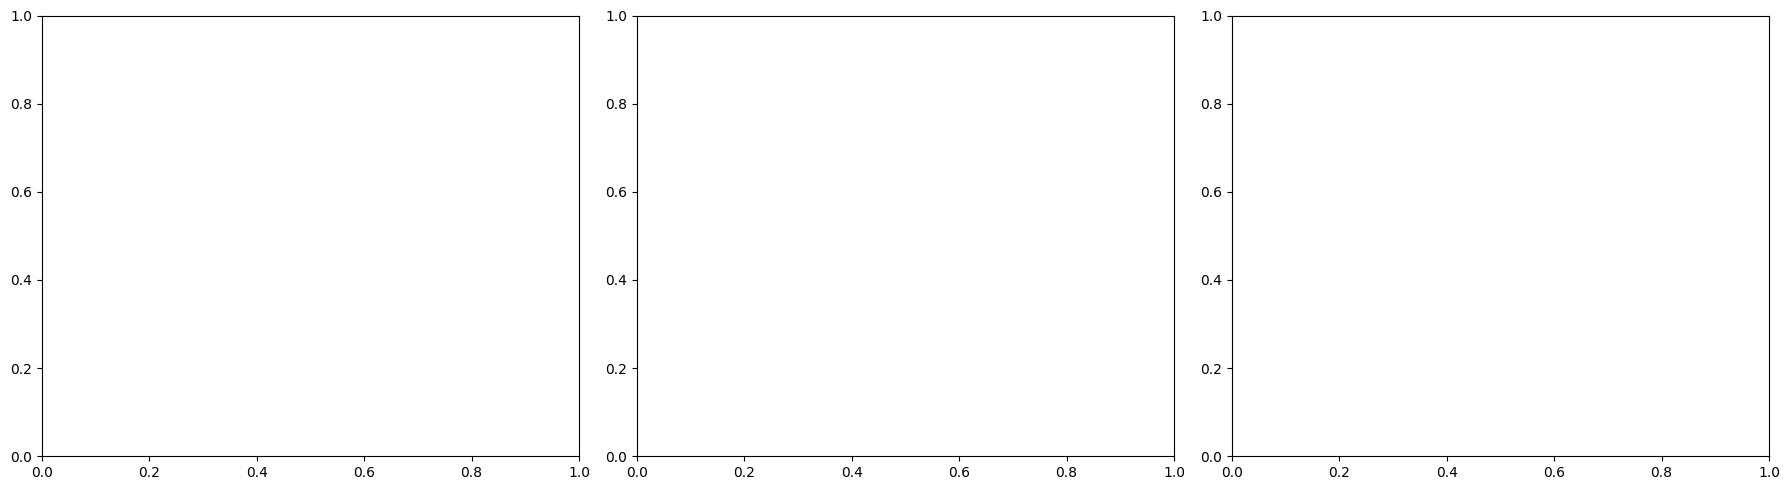

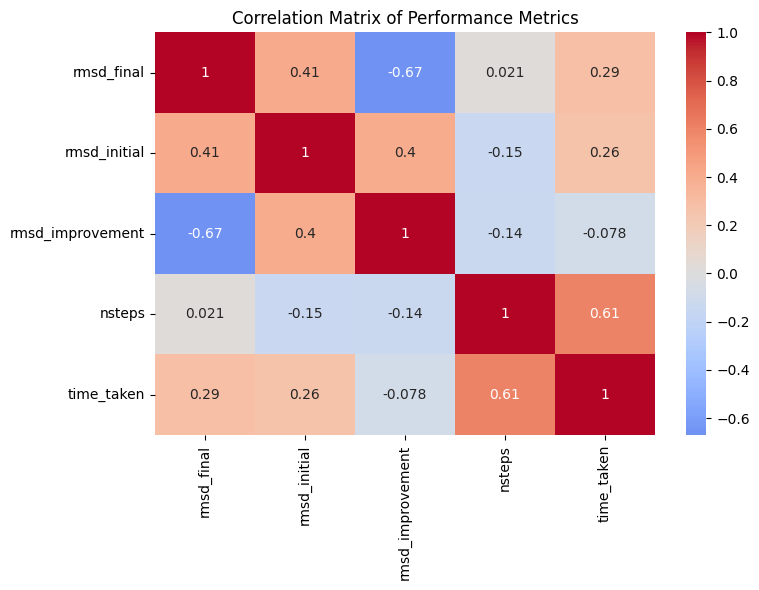

In [7]:
if len(summary_files) > 0:
    # Analyze other performance metrics if available
    metrics_to_plot = []
    
    if 'time_taken' in df_clean.columns:
        metrics_to_plot.append('time_taken')
    if 'rmsd_improvement' in df_clean.columns:
        metrics_to_plot.append('rmsd_improvement')
    if 'nsteps' in df_clean.columns:
        metrics_to_plot.append('nsteps')
    
    if metrics_to_plot:
        n_metrics = len(metrics_to_plot)
        fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 5))
        if n_metrics == 1:
            axes = [axes]
        
        for i, metric in enumerate(metrics_to_plot):
            df_metric = df_clean.dropna(subset=[metric, 'starting_point', 'hessian_method'])
            
            if len(df_metric) > 0:
                sns.boxplot(data=df_metric, x='starting_point', y=metric, 
                           hue='hessian_method', ax=axes[i])
                axes[i].set_title(f'{metric.replace("_", " ").title()} by Configuration')
                axes[i].tick_params(axis='x', rotation=45)
                if i > 0:
                    axes[i].get_legend().remove()
        
        plt.tight_layout()
        plt.show()
    
    # Create correlation matrix if multiple metrics available
    numeric_cols = ['rmsd_final', 'rmsd_initial', 'rmsd_improvement', 'nsteps', 'time_taken']
    available_numeric = [col for col in numeric_cols if col in df_clean.columns]
    
    if len(available_numeric) > 1:
        fig, ax = plt.subplots(figsize=(8, 6))
        correlation_matrix = df_clean[available_numeric].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax)
        ax.set_title('Correlation Matrix of Performance Metrics')
        plt.tight_layout()
        plt.show()


In [8]:
# if len(summary_files) > 0:
#     # Save the cleaned dataframe
#     output_file = "sella_results_analysis.csv"
#     df_clean.to_csv(output_file, index=False)
#     print(f"Saved cleaned results to {output_file}")
    
#     # Save summary statistics
#     summary_stats = {
#         'total_runs': len(df_clean),
#         'successful_runs': len(df_clean.dropna(subset=['rmsd_final'])),
#         'starting_points': df_clean['starting_point'].value_counts().to_dict(),
#         'hessian_methods': df_clean['hessian_method'].value_counts().to_dict(),
#         'coordinate_systems': df_clean['coordinate_system'].value_counts().to_dict()
#     }
    
#     with open('sella_results_summary.json', 'w') as f:
#         json.dump(summary_stats, f, indent=2)
    
#     print(f"Saved summary statistics to sella_results_summary.json")
#     print(f"\nAnalysis complete! Processed {len(df_clean)} Sella optimization runs.")
# else:
#     print("No data to export. Run Sella optimization first.")
